In [1]:
cd ..

m:\OneDrive\Projects\federated_imputation_pc1


In [2]:
#Loading libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [47]:
#loading Dataset
df = pd.read_csv("./data/diabetic/diabetic_data.csv")
df.shape

(101766, 50)

## Dealing with Missing Values
Variable weight contains approximate 98% of the missing values so there is no significance in filling those missing values so we decided to drop these variables. Variable Payer code and medical specialty contains approximate 40% missing values so we also dropped these variables. Variables race, diag_1, diag_2, diag_3 and gender contains very less missing values as compared to other attributes which we dropped so for these attributes we also decided to drop those where missing values contains.

In [48]:
#dropping columns with large number of missing values
df = df.drop(['weight','payer_code','medical_specialty'], axis = 1)
drop_Idx = set(df[(df['diag_1'] == '?') & (df['diag_2'] == '?') & (df['diag_3'] == '?')].index)

drop_Idx = drop_Idx.union(set(df['diag_1'][df['diag_1'] == '?'].index))
drop_Idx = drop_Idx.union(set(df['diag_2'][df['diag_2'] == '?'].index))
drop_Idx = drop_Idx.union(set(df['diag_3'][df['diag_3'] == '?'].index))
drop_Idx = drop_Idx.union(set(df['race'][df['race'] == '?'].index))
drop_Idx = drop_Idx.union(set(df[df['discharge_disposition_id'] == 11].index))
drop_Idx = drop_Idx.union(set(df['gender'][df['gender'] == 'Unknown/Invalid'].index))
new_Idx = list(set(df.index) - set(drop_Idx))
df = df.iloc[new_Idx]

df = df.drop(['citoglipton', 'examide'], axis = 1)
df[['A1Cresult', 'max_glu_serum']] = df[['A1Cresult', 'max_glu_serum']].fillna('None')

## Feature Engineering

In [50]:
# service utilization
df['service_utilization'] = df['number_outpatient'] + df['number_emergency'] + df['number_inpatient']

# number of changes in medications
keys = [
    'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'glipizide', 
    'glyburide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'insulin', 
    'glyburide-metformin', 'tolazamide', 'metformin-pioglitazone','metformin-rosiglitazone', 
    'glimepiride-pioglitazone', 'glipizide-metformin', 'troglitazone', 
    'tolbutamide', 'acetohexamide'
]
for col in keys:
    colname = str(col) + 'temp'
    df[colname] = df[col].apply(lambda x: 0 if (x == 'No' or x == 'Steady') else 1)
df['numchange'] = 0
for col in keys:
    colname = str(col) + 'temp'
    df['numchange'] = df['numchange'] + df[colname]
    del df[colname]

# encoding
df['change'] = df['change'].replace('Ch', 1)
df['change'] = df['change'].replace('No', 0)
df['gender'] = df['gender'].replace('Male', 1)
df['gender'] = df['gender'].replace('Female', 0)
df['diabetesMed'] = df['diabetesMed'].replace('Yes', 1)
df['diabetesMed'] = df['diabetesMed'].replace('No', 0)
# keys is the same as before
for col in keys:
    df[col] = df[col].map({"No": 0, "Steady": 1, "Up": 1, "Down": 1})

df['A1Cresult'] = df['A1Cresult'].map({'>7': 1, ">8": 1, "Norm": 0, "None": -99})
df['max_glu_serum'] = df['max_glu_serum'].map({">200":1, ">300": 1, "Norm": 0, "None": -99})

# age
for i in range(0,10):
    df['age'] = df['age'].replace('['+str(10*i)+'-'+str(10*(i+1))+')', i+1)
df['age'] = df['age'].astype('int64')
age_dict = {1:5, 2:15, 3:25, 4:35, 5:45, 6:55, 7:65, 8:75, 9:85, 10:95}
df['age'] = df.age.map(age_dict)

In [52]:
# re-encoding admission type, discharge type and admission source into fewer categories
df['admission_type_id'] = df['admission_type_id'].map({
    1: 1, 2:1, 3:3, 4:4, 5:5, 6:5, 7:1, 8:5
})

def mapping_discharge_id(x):
    if x in [1,6,8,9,13]:
        return 1
    elif x in [3,4,5,14,22,23,24]:
        return 2
    elif x in [12,15,16,17]:
        return 10
    elif x in [25,26]:
        return 18
    else:
        return x
df['discharge_disposition_id'] = df['discharge_disposition_id'].apply(lambda row: mapping_discharge_id(row))

def mapping_admission_id(x):
    if x in [1,2,3]:
        return 1
    elif x in [4,5,6,10,22,25]:
        return 4
    elif x in [9,15,17,20,21]:
        return 9
    elif x in [11,13,14]:
        return 11
    else:
        return x

df['admission_source_id'] = df['admission_source_id'].apply(lambda row: mapping_admission_id(row))

In [53]:
# drop duplicate patient_nbr
df2 = df.drop_duplicates(subset= ['patient_nbr'], keep = 'first')
df2.shape
(70442, 55)

(70442, 55)

In [54]:
df['readmitted'] = df['readmitted'].replace('>30', 0)
df['readmitted'] = df['readmitted'].replace('<30', 1)
df['readmitted'] = df['readmitted'].replace('NO', 0)

In [55]:
# Creating additional columns for diagnosis# Creati 
df['level1_diag1'] = df['diag_1']
df['level2_diag1'] = df['diag_1']
df['level1_diag2'] = df['diag_2']
df['level2_diag2'] = df['diag_2']
df['level1_diag3'] = df['diag_3']
df['level2_diag3'] = df['diag_3']
df.loc[df['diag_1'].str.contains('V'), ['level1_diag1', 'level2_diag1']] = 0
df.loc[df['diag_1'].str.contains('E'), ['level1_diag1', 'level2_diag1']] = 0
df.loc[df['diag_2'].str.contains('V'), ['level1_diag2', 'level2_diag2']] = 0
df.loc[df['diag_2'].str.contains('E'), ['level1_diag2', 'level2_diag2']] = 0
df.loc[df['diag_3'].str.contains('V'), ['level1_diag3', 'level2_diag3']] = 0
df.loc[df['diag_3'].str.contains('E'), ['level1_diag3', 'level2_diag3']] = 0
df['level1_diag1'] = df['level1_diag1'].replace('?', -1)
df['level2_diag1'] = df['level2_diag1'].replace('?', -1)
df['level1_diag2'] = df['level1_diag2'].replace('?', -1)
df['level2_diag2'] = df['level2_diag2'].replace('?', -1)
df['level1_diag3'] = df['level1_diag3'].replace('?', -1)
df['level2_diag3'] = df['level2_diag3'].replace('?', -1)
df['level1_diag1'] = df['level1_diag1'].astype(float)
df['level2_diag1'] = df['level2_diag1'].astype(float)
df['level1_diag2'] = df['level1_diag2'].astype(float)
df['level2_diag2'] = df['level2_diag2'].astype(float)
df['level1_diag3'] = df['level1_diag3'].astype(float)
df['level2_diag3'] = df['level2_diag3'].astype(float)

def encode_diag(row, key = 'level1_diag1'):
    if (row[key] >= 390 and row[key] < 460) or (np.floor(row[key]) == 785):
        return 1
    elif (row[key] >= 460 and row[key] < 520) or (np.floor(row[key]) == 786):
        return 2
    elif (row[key] >= 520 and row[key] < 580) or (np.floor(row[key]) == 787):
        return 3
    elif (np.floor(row[key]) == 250):
        return 4
    elif (row[key] >= 800 and row[key] < 1000):
        return 5
    elif (row[key] >= 710 and row[key] < 740):
        return 6
    elif (row[key] >= 580 and row[key] < 630) or (np.floor(row[key]) == 788):
        return 7
    elif (row[key] >= 140 and row[key] < 240):
        return 8
    else:
        return 0
    
df['level1_diag1'] = df.apply(lambda row: encode_diag(row, 'level1_diag1'), axis = 1)
df['level1_diag2'] = df.apply(lambda row: encode_diag(row, 'level1_diag2'), axis = 1)
df['level1_diag3'] = df.apply(lambda row: encode_diag(row, 'level1_diag3'), axis = 1)

def encode_diag2(row, key):
    if (row[key] >= 390 and row[key] < 399):
        return 1
    elif (row[key] >= 401 and row[key] < 415):
        return 2
    elif (row[key] >= 415 and row[key] < 460):
        return 3
    elif (np.floor(row[key]) == 785):
        return 4
    elif (row[key] >= 460 and row[key] < 489):
        return 5
    elif (row[key] >= 490 and row[key] < 497):
        return 6
    elif (row[key] >= 500 and row[key] < 520):
        return 7
    elif (np.floor(row[key]) == 786):
        return 8
    elif (row[key] >= 520 and row[key] < 530):
        return 9
    elif (row[key] >= 530 and row[key] < 544):
        return 10
    elif (row[key] >= 550 and row[key] < 554):
        return 11
    elif (row[key] >= 555 and row[key] < 580):
        return 12
    elif (np.floor(row[key]) == 787):
        return 13
    elif (np.floor(row[key]) == 250):
        return 14
    elif (row[key] >= 800 and row[key] < 1000):
        return 15
    elif (row[key] >= 710 and row[key] < 740):
        return 16
    elif (row[key] >= 580 and row[key] < 630):
        return 17
    elif (np.floor(row[key]) == 788):
        return 18
    elif (row[key] >= 140 and row[key] < 240):
        return 19
    elif row[key] >= 240 and row[key] < 280 and (np.floor(row[key]) != 250):
        return 20
    elif (row[key] >= 680 and row[key] < 710) or (np.floor(row[key]) == 782):
        return 21
    elif (row[key] >= 290 and row[key] < 320):
        return 22
    else:
        return 0

df['level2_diag1'] = df.apply(lambda row: encode_diag2(row, 'level2_diag1'), axis=1)
df['level2_diag2'] = df.apply(lambda row: encode_diag2(row, 'level2_diag2'), axis=1)
df['level2_diag3'] = df.apply(lambda row: encode_diag2(row, 'level2_diag3'), axis=1)

In [58]:
# convert data type of nominal features in dataframe to 'object' type
i = [
    'encounter_id', 'patient_nbr', 'gender', 'admission_type_id',  'discharge_disposition_id', 
    'admission_source_id', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 
    'glimepiride', 'acetohexamide',  'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 
    'rosiglitazone', 'acarbose','miglitol', 'troglitazone', 'tolazamide', 'insulin', 
    'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 
    'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed', 'age', 
    'A1Cresult', 'max_glu_serum', 'level1_diag1', 'level1_diag2', 'level1_diag3', 
    'level2_diag1', 'level2_diag2', 'level2_diag3'
]
for col in i:
    df[col] = df[col].astype('object')

In [60]:
df['nummed'] = 0

for col in keys:
    df['nummed'] = df['nummed'] + df[col]
df['nummed'].value_counts()

nummed
1    44589
0    22156
2    20901
3     7448
4     1290
5       57
6        5
Name: count, dtype: int64

In [62]:
# Removing skewnewss and kurtosis using log transformation if it is above a threshold value -  2
num_col = list(set(list(df._get_numeric_data().columns))- {'readmitted'})
statdataframe = pd.DataFrame()
statdataframe['numeric_column'] = num_col
skew_before = []
skew_after = []

kurt_before = []
kurt_after = []

standard_deviation_before = []
standard_deviation_after = []

log_transform_needed = []

log_type = []

for i in num_col:
    skewval = df[i].skew()
    skew_before.append(skewval)
    
    kurtval = df[i].kurtosis()
    kurt_before.append(kurtval)
    
    sdval = df[i].std()
    standard_deviation_before.append(sdval)
    
    if (abs(skewval) >2) & (abs(kurtval) >2):
        log_transform_needed.append('Yes')
        
        if len(df[df[i] == 0])/len(df) <=0.02:
            log_type.append('log')
            skewvalnew = np.log(pd.DataFrame(df[train_data[i] > 0])[i]).skew()
            skew_after.append(skewvalnew)
            
            kurtvalnew = np.log(pd.DataFrame(df[train_data[i] > 0])[i]).kurtosis()
            kurt_after.append(kurtvalnew)
            
            sdvalnew = np.log(pd.DataFrame(df[train_data[i] > 0])[i]).std()
            standard_deviation_after.append(sdvalnew)
            
        else:
            log_type.append('log1p')
            skewvalnew = np.log1p(pd.DataFrame(df[df[i] >= 0])[i]).skew()
            skew_after.append(skewvalnew)
        
            kurtvalnew = np.log1p(pd.DataFrame(df[df[i] >= 0])[i]).kurtosis()
            kurt_after.append(kurtvalnew)
            
            sdvalnew = np.log1p(pd.DataFrame(df[df[i] >= 0])[i]).std()
            standard_deviation_after.append(sdvalnew)
            
    else:
        log_type.append('NA')
        log_transform_needed.append('No')
        
        skew_after.append(skewval)
        kurt_after.append(kurtval)
        standard_deviation_after.append(sdval)

statdataframe['skew_before'] = skew_before
statdataframe['kurtosis_before'] = kurt_before
statdataframe['standard_deviation_before'] = standard_deviation_before
statdataframe['log_transform_needed'] = log_transform_needed
statdataframe['log_type'] = log_type
statdataframe['skew_after'] = skew_after
statdataframe['kurtosis_after'] = kurt_after
statdataframe['standard_deviation_after'] = standard_deviation_after

In [63]:
# performing the log transformation for the columns determined to be needing it above.

for i in range(len(statdataframe)):
    if statdataframe['log_transform_needed'][i] == 'Yes':
        colname = str(statdataframe['numeric_column'][i])
        
        if statdataframe['log_type'][i] == 'log':
            df = df[df[colname] > 0]
            df[colname + "_log"] = np.log(df[colname])
            
        elif statdataframe['log_type'][i] == 'log1p':
            df = df[df[colname] >= 0]
            df[colname + "_log1p"] = np.log1p(df[colname])

In [64]:
df = df.drop(['number_outpatient', 'number_inpatient', 'number_emergency','service_utilization'], axis = 1)

In [65]:
df.shape

(96446, 54)

In [67]:
# get list of only numeric features
numerics = list(set(list(df._get_numeric_data().columns))- {'readmitted'})

In [68]:
# show list of features that are categorical
df.encounter_id = df.encounter_id.astype('int64')
df.patient_nbr = df.patient_nbr.astype('int64')
df.diabetesMed = df.diabetesMed.astype('int64')
df.change = df.change.astype('int64')

# convert data type of nominal features in dataframe to 'object' type for aggregating
i = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', \
          'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose','miglitol', \
          'troglitazone', 'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin', \
          'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone','A1Cresult']
df[i] = df[i].astype('int64')

encounter_id                   int64
patient_nbr                    int64
race                          object
gender                        object
age                           object
admission_type_id             object
discharge_disposition_id      object
admission_source_id           object
time_in_hospital               int64
num_lab_procedures             int64
num_procedures                 int64
num_medications                int64
diag_1                        object
diag_2                        object
diag_3                        object
number_diagnoses               int64
max_glu_serum                 object
A1Cresult                      int64
metformin                      int64
repaglinide                    int64
nateglinide                    int64
chlorpropamide                 int64
glimepiride                    int64
acetohexamide                  int64
glipizide                      int64
glyburide                      int64
tolbutamide                    int64
p

In [69]:
dfcopy = df.copy(deep = True)

In [70]:
df['readmitted'] = df['readmitted'].apply(lambda x: 0 if x == 2 else x)

In [71]:
# drop individual diagnosis columns that have too granular disease information
# also drop level 2 categorization (which was not comparable with any reference)
# also drop level 1 secondary and tertiary diagnoses
df.drop(['diag_1', 'diag_2', 'diag_3', 'level2_diag1', 'level1_diag2', 'level2_diag2', 'level1_diag3',
         'level2_diag3'], axis=1, inplace=True)

In [72]:
interactionterms = [('num_medications','time_in_hospital'),
('num_medications','num_procedures'),
('time_in_hospital','num_lab_procedures'),
('num_medications','num_lab_procedures'),
('num_medications','number_diagnoses'),
('age','number_diagnoses'),
('change','num_medications'),
('number_diagnoses','time_in_hospital'),
('num_medications','numchange')]

In [73]:
for inter in interactionterms:
    name = inter[0] + '|' + inter[1]
    df[name] = df[inter[0]] * df[inter[1]]

In [75]:
# Feature Scaling
datf = pd.DataFrame()
datf['features'] = numerics
datf['std_dev'] = datf['features'].apply(lambda x: df[x].std())
datf['mean'] = datf['features'].apply(lambda x: df[x].mean())

In [76]:
# dropping multiple encounters while keeping either first or last encounter of these patients
df2 = df.drop_duplicates(subset= ['patient_nbr'], keep = 'first')
df2.shape

(67580, 55)

In [77]:
# standardize function
def standardize(raw_data):
    return ((raw_data - np.mean(raw_data, axis = 0)) / np.std(raw_data, axis = 0))

In [78]:
df2[numerics] = standardize(df2[numerics])
import scipy as sp
df2 = df2[(np.abs(sp.stats.zscore(df2[numerics])) < 3).all(axis=1)]

C:\Users\sitao\AppData\Local\Temp\ipykernel_18828\1394421667.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[numerics] = standardize(df2[numerics])


In [80]:
df2['level1_diag1'] = df2['level1_diag1'].astype('object')
df_pd = pd.get_dummies(df2, columns=['gender', 'admission_type_id', 'discharge_disposition_id',
                                      'admission_source_id', 'max_glu_serum', 'A1Cresult', 'level1_diag1'], drop_first = True)
just_dummies = pd.get_dummies(df_pd['race'])
df_pd = pd.concat([df_pd, just_dummies], axis=1)      
df_pd.drop(['race'], inplace=True, axis=1)

In [81]:
non_num_cols = ['race', 'gender', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 
                'max_glu_serum', 'A1Cresult', 'level1_diag1' ]

In [82]:
num_cols = list(set(list(df._get_numeric_data().columns))- {'readmitted', 'change'})
num_cols

['number_diagnoses',
 'num_medications|numchange',
 'repaglinide',
 'tolazamide',
 'glyburide-metformin',
 'acetohexamide',
 'insulin',
 'glimepiride-pioglitazone',
 'A1Cresult',
 'glimepiride',
 'miglitol',
 'number_inpatient_log1p',
 'chlorpropamide',
 'num_lab_procedures',
 'metformin-rosiglitazone',
 'glipizide',
 'acarbose',
 'num_medications|num_lab_procedures',
 'num_medications|num_procedures',
 'change|num_medications',
 'number_outpatient_log1p',
 'diabetesMed',
 'num_medications',
 'num_procedures',
 'tolbutamide',
 'glyburide',
 'number_emergency_log1p',
 'numchange',
 'service_utilization_log1p',
 'time_in_hospital|num_lab_procedures',
 'nateglinide',
 'metformin',
 'patient_nbr',
 'rosiglitazone',
 'num_medications|number_diagnoses',
 'num_medications|time_in_hospital',
 'encounter_id',
 'metformin-pioglitazone',
 'number_diagnoses|time_in_hospital',
 'glipizide-metformin',
 'troglitazone',
 'time_in_hospital',
 'pioglitazone']

In [83]:
new_non_num_cols = []
for i in non_num_cols:
    for j in df_pd.columns:
        if i in j:
            new_non_num_cols.append(j)

In [84]:
l = []
for feature in list(df_pd.columns):
    if '|' in feature:
        l.append(feature)
l

['num_medications|time_in_hospital',
 'num_medications|num_procedures',
 'time_in_hospital|num_lab_procedures',
 'num_medications|num_lab_procedures',
 'num_medications|number_diagnoses',
 'age|number_diagnoses',
 'change|num_medications',
 'number_diagnoses|time_in_hospital',
 'num_medications|numchange']

## Modeling

In [89]:
df_pd.columns

Index(['encounter_id', 'patient_nbr', 'age', 'time_in_hospital',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_diagnoses', 'metformin', 'repaglinide', 'nateglinide',
       'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'troglitazone', 'tolazamide', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted',
       'numchange', 'nummed', 'number_outpatient_log1p',
       'number_inpatient_log1p', 'service_utilization_log1p',
       'number_emergency_log1p', 'num_medications|time_in_hospital',
       'num_medications|num_procedures', 'time_in_hospital|num_lab_procedures',
       'num_medications|num_lab_procedures',
       'num_medications|number_diagnoses', 'age|number_diagnoses',
       'change|num_med

In [90]:
feature_set = [
    'age', 'time_in_hospital', 'num_procedures', 'num_medications', 'number_outpatient_log1p', 
    'number_emergency_log1p', 'number_inpatient_log1p', 'number_diagnoses', 'metformin', 
    'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'glipizide', 'glyburide',
    'pioglitazone', 'rosiglitazone', 'acarbose', 'tolazamide', 'insulin', 'glyburide-metformin',
    'AfricanAmerican', 'Asian', 'Caucasian', 'Hispanic', 'Other', 'gender_1', 
    'admission_type_id_3', 'admission_type_id_5', 'discharge_disposition_id_2', 'discharge_disposition_id_7', 
    'discharge_disposition_id_10', 'discharge_disposition_id_18', 'admission_source_id_4',
    'admission_source_id_7', 'admission_source_id_9', 'max_glu_serum_0', 'max_glu_serum_1', 'A1Cresult_0',
    'A1Cresult_1', 'num_medications|time_in_hospital', 'num_medications|num_procedures',
    'time_in_hospital|num_lab_procedures', 'num_medications|num_lab_procedures', 'num_medications|number_diagnoses',
    'age|number_diagnoses', 'change|num_medications', 'number_diagnoses|time_in_hospital',
    'num_medications|numchange', 'level1_diag1_1', 'level1_diag1_2', 'level1_diag1_3', 'level1_diag1_4',
    'level1_diag1_5','level1_diag1_6', 'level1_diag1_7', 'level1_diag1_8'
]

In [91]:
X = df_pd[feature_set]
y = df_pd['readmitted']

In [92]:
print(X.shape, y.shape)

(59706, 57) (59706,)


In [95]:
y.value_counts()

readmitted
0    54635
1     5071
Name: count, dtype: int64

In [127]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn import metrics
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=21, stratify=y
)

sm = RandomOverSampler(random_state=21)
X_train, y_train = sm.fit_resample(X_train, y_train)

clf = MLPClassifier(
    hidden_layer_sizes=(32, 32),
    batch_size=128,
    max_iter=2000,
    alpha=0.01,
    solver='adam',
    verbose=False,
    tol=0.000000001,
    random_state=21,
    learning_rate_init=0.01,
    early_stopping=False,
    n_iter_no_change=10
)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[:, 1]
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test, y_pred))
print("ROC AUC score:", metrics.roc_auc_score(y_test, y_pred_proba))



Accuracy: 0.5375146541617819
Recall: 0.5739644970414202
Precision: 0.10259122157588578
ROC AUC score: 0.5612559778041533


### Random Forest

In [86]:
X = df_pd[feature_set_no_int]
y = df_pd['readmitted']

print('Original dataset shape {}'.format(Counter(y)))
smt = SMOTE(random_state=20)
train_input_new, train_output_new = smt.fit_sample(X, y)
print('New dataset shape {}'.format(Counter(train_output_new)))
train_input_new = pd.DataFrame(train_input_new, columns = list(X.columns))
X_train, X_test, y_train, y_test = train_test_split(train_input_new, train_output_new, test_size=0.20, random_state=0)

Original dataset shape Counter({0: 54635, 1: 5071})
New dataset shape Counter({0: 54635, 1: 54635})


In [87]:
from sklearn.ensemble import RandomForestClassifier
rm = RandomForestClassifier(n_estimators = 10, max_depth=25, criterion = "gini", min_samples_split=10)
rm.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=25, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [88]:
rm_prd = rm.predict(X_test)
pd.crosstab(pd.Series(y_test, name = 'Actual'), pd.Series(rm_prd, name = 'Predict'), margins = True)

Predict,0,1,All
Actual,,,
0,10795,141,10936
1,1141,9777,10918
All,11936,9918,21854


In [89]:
print("Accuracy is {0:.2f}".format(accuracy_score(y_test, rm_prd)))
print("Precision is {0:.2f}".format(precision_score(y_test, rm_prd)))
print("Recall is {0:.2f}".format(recall_score(y_test, rm_prd)))

accuracy_rm = accuracy_score(y_test, rm_prd)
precision_rm = precision_score(y_test, rm_prd)
recall_rm = recall_score(y_test, rm_prd)

Accuracy is 0.94
Precision is 0.99
Recall is 0.90


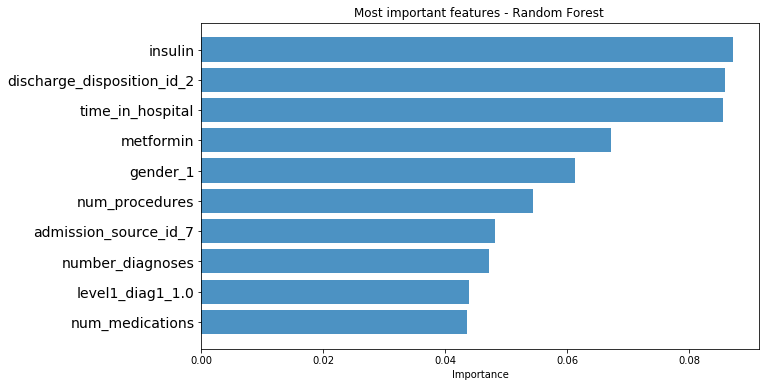

In [90]:
# Create list of top most features based on importance
feature_names = X_train.columns
feature_imports = rm.feature_importances_
most_imp_features = pd.DataFrame([f for f in zip(feature_names,feature_imports)], columns=["Feature", "Importance"]).nlargest(10, "Importance")
most_imp_features.sort_values(by="Importance", inplace=True)
plt.figure(figsize=(10,6))
plt.barh(range(len(most_imp_features)), most_imp_features.Importance, align='center', alpha=0.8)
plt.yticks(range(len(most_imp_features)), most_imp_features.Feature, fontsize=14)
plt.xlabel('Importance')
plt.title('Most important features - Random Forest ')
plt.show()

## Model Comparision

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


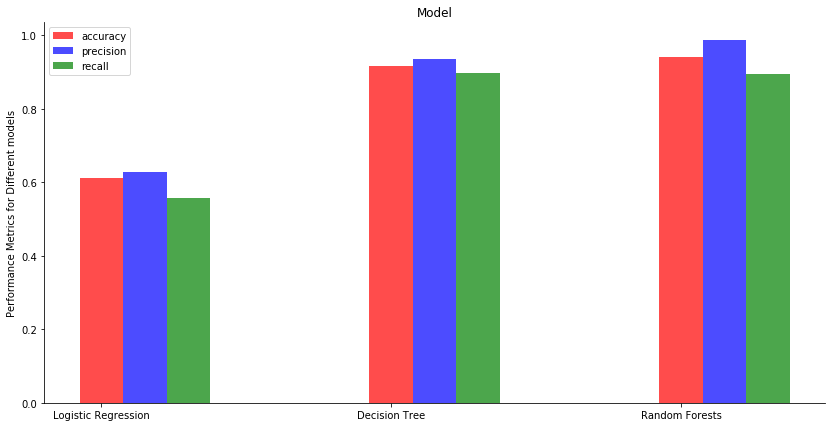

In [91]:
plt.figure(figsize=(14, 7))
ax = plt.subplot(111)

models = ['Logistic Regression', 'Decision Tree', 'Random Forests']
values = [accuracy_logit, accuracy_dtree, accuracy_rm]
model = np.arange(len(models))

plt.bar(model, values, align='center', width = 0.15, alpha=0.7, color = 'red', label= 'accuracy')
plt.xticks(model, models)
           

           
ax = plt.subplot(111)

models = ['Logistic Regression', 'Decision Tree', 'Random Forests']
values = [precision_logit, precision_dtree, precision_rm]
model = np.arange(len(models))

plt.bar(model+0.15, values, align='center', width = 0.15, alpha=0.7, color = 'blue', label = 'precision')
plt.xticks(model, models)



ax = plt.subplot(111)

models = ['Logistic Regression', 'Decision Tree', 'Random Forests' ]
values = [recall_logit, recall_dtree, recall_rm, ]
model = np.arange(len(models))

plt.bar(model+0.3, values, align='center', width = 0.15, alpha=0.7, color = 'green', label = 'recall')
plt.xticks(model, models)



plt.ylabel('Performance Metrics for Different models')
plt.title('Model')
    
# removing the axis on the top and right of the plot window
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend()

plt.show()           